<a href="https://colab.research.google.com/github/devansh173/heart-disease-prediction-using-ensemble/blob/main/ensemble_heart_disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import all the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import math
import random
import os
import time
from numpy import interp

# Disabling warnings:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Apply some Styles:

cust_palt = [
    '#111d5e', '#c70039', '#f37121', '#ffbd69', '#ffc93c'
]
plt.style.use('ggplot')

In [ ]:
# Seeding:

def seed_all(seed):

    ''' A function to seed everything for getting stable results and reproducibility'''

    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed = 42
seed_all(seed)

x=144
y=123

In [ ]:
# Reading the csv file:
from google.colab import files
uploaded = files.upload()

Saving heart disease dataset.csv to heart disease dataset.csv


In [ ]:
import pandas as pd
import io
#df = pd.read_csv(io.BytesIO(uploaded['heart_cleveland_upload.csv']))
train = pd.read_csv(io.BytesIO(uploaded["heart disease dataset.csv"]))
print(train)

      age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0      52    1   0       125   212    0        1      168      0      1.0   
1      53    1   0       140   203    1        0      155      1      3.1   
2      70    1   0       145   174    0        1      125      1      2.6   
3      61    1   0       148   203    0        1      161      0      0.0   
4      62    0   0       138   294    1        1      106      0      1.9   
...   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
1020   59    1   1       140   221    0        1      164      1      0.0   
1021   60    1   0       125   258    0        0      141      1      2.8   
1022   47    1   0       110   275    0        0      118      1      1.0   
1023   50    0   0       110   254    0        0      159      0      0.0   
1024   54    1   0       120   188    0        1      113      0      1.4   

      slope  ca  thal  target  
0         2   2     3       0  
1         0

In [ ]:
#Print the first "5" records
# and convert into an attractive table
train.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [ ]:
print(
    f'Train data has {train.shape[1]} features, {train.shape[0]} observations.\nTrain features are:\n{train.columns.tolist()}\n'
)

Train data has 14 features, 1025 observations.
Train features are:
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']



In [ ]:
train.isnull().sum().sum()


0

In [ ]:
train.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'condition']

In [ ]:
train.nunique()


,0
age,41
sex,2
chest_pain_type,4
resting_blood_pressure,49
cholesterol,152
fasting_blood_sugar,2
rest_ecg,3
max_heart_rate_achieved,91
exercise_induced_angina,2
st_depression,40


In [ ]:
# Further, RENAME cateorical data for easier understanding:

train['sex'] = train['sex'].map({0:'female',1:'male'})

train['chest_pain_type'] = train['chest_pain_type'].map({3:'asymptomatic', 1:'atypical_angina', 2:'non_anginal_pain', 0:'typical_angina'})

train['fasting_blood_sugar'] = train['fasting_blood_sugar'].map({0:'less_than_120mg/ml',1:'greater_than_120mg/ml'})

train['rest_ecg'] = train['rest_ecg'].map({0:'normal',1:'ST-T_wave_abnormality',2:'left_ventricular_hypertrophy'})

train['exercise_induced_angina'] = train['exercise_induced_angina'].map({0:'no',1:'yes'})

train['st_slope'] = train['st_slope'].map({0:'upsloping',1:'flat',2:'downsloping'})

train['thalassemia'] = train['thalassemia'].map({1:'fixed_defect',0:'normal',2:'reversable_defect'})

train['condition'] = train['condition'].map({0:'no_disease', 1:'has_disease'})


In [ ]:
# Apply Masks (MASKING) for easier selection in the future:

categorical = [i for i in train.loc[:,train.nunique()<=10]]
continuous = [i for i in train.loc[:,train.nunique()>=10]]

In [ ]:
def ctg_dist(df, cols, hue=None,rows=3, columns=3):

    '''A function for displaying cateorical distribution'''

    fig, axes = plt.subplots(rows, columns, figsize=(16, 12))
    axes = axes.flatten()

    for i, j in zip(df[cols].columns, axes):
        sns.countplot(x=i,
                    data=df,
                    palette=cust_palt,
                    hue=hue,
                    ax=j,
                    order=df[i].value_counts().index)
        j.tick_params(labelrotation=10)

        total = float(len(df[i]))

        j.set_title(f'{str(i).capitalize()} Distribution')


        for p in j.patches:
            height = p.get_height()
            j.text(p.get_x() + p.get_width() / 2.,
                    height + 2,
                    '{:1.2f}%'.format((height / total) * 100),
                    ha='center')

        plt.tight_layout()

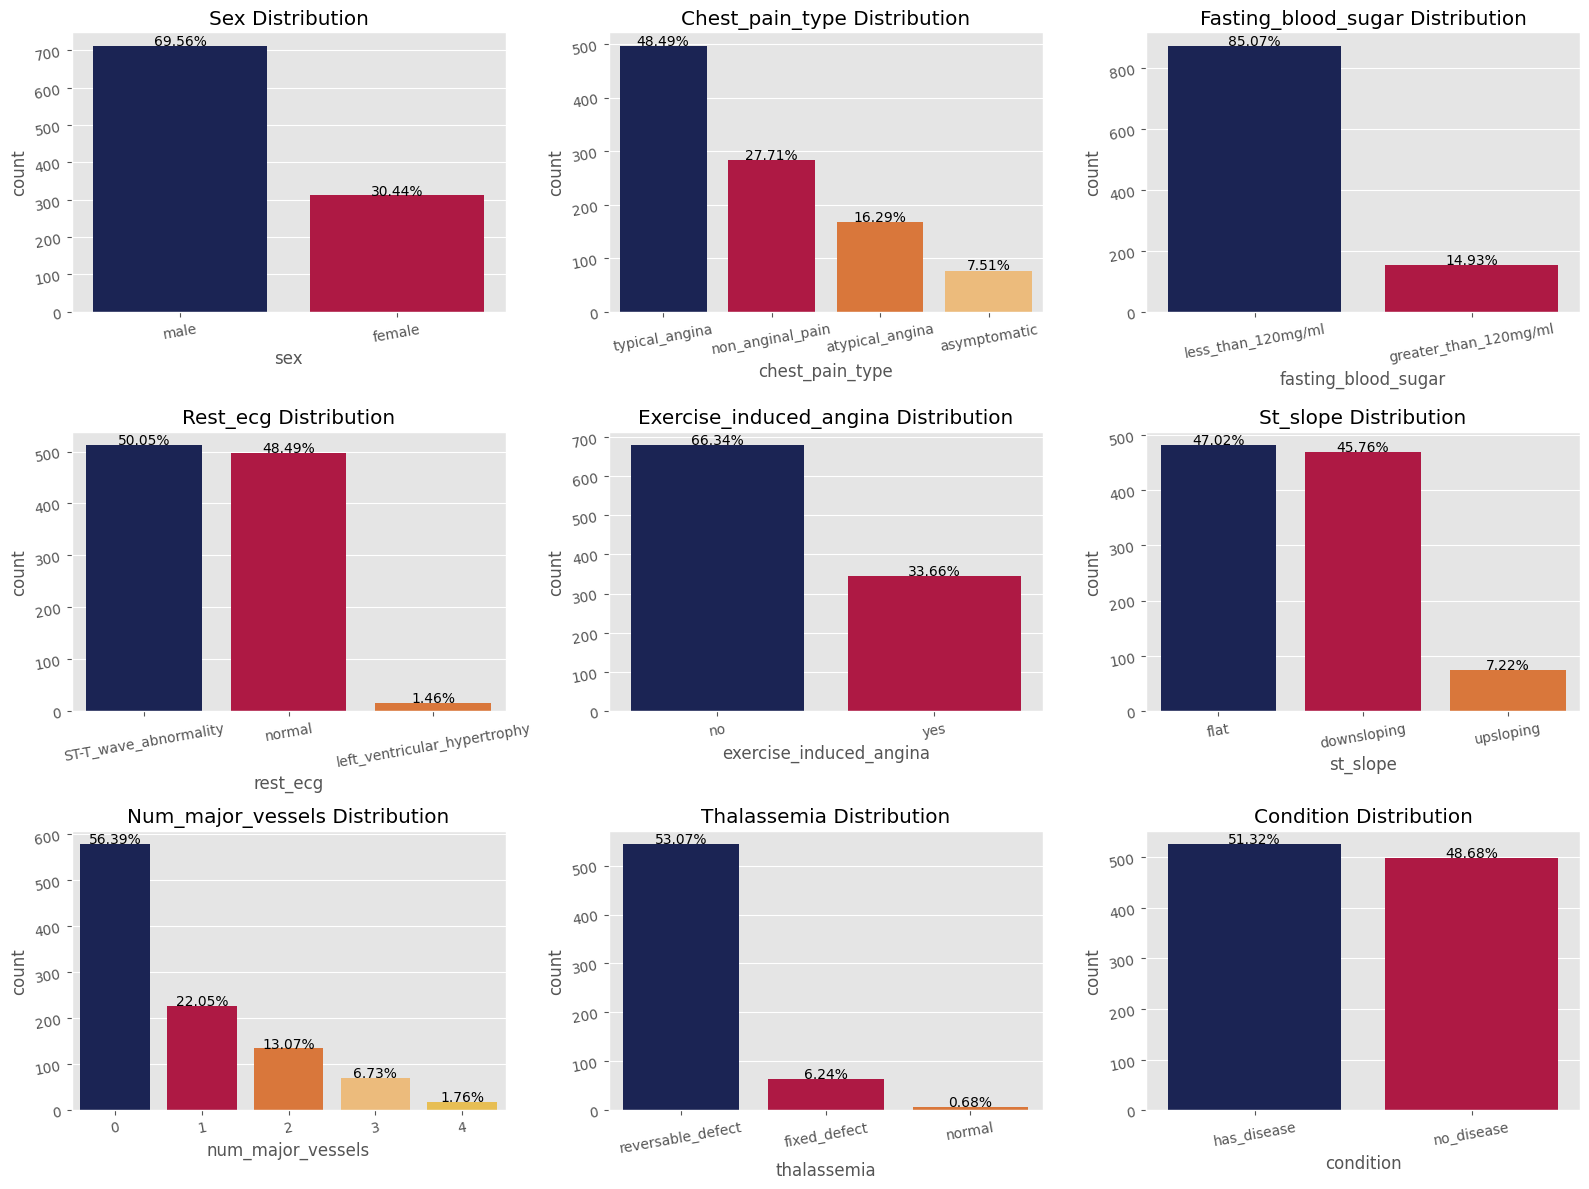

In [ ]:
# Display categorical data:

ctg_dist(train, categorical)

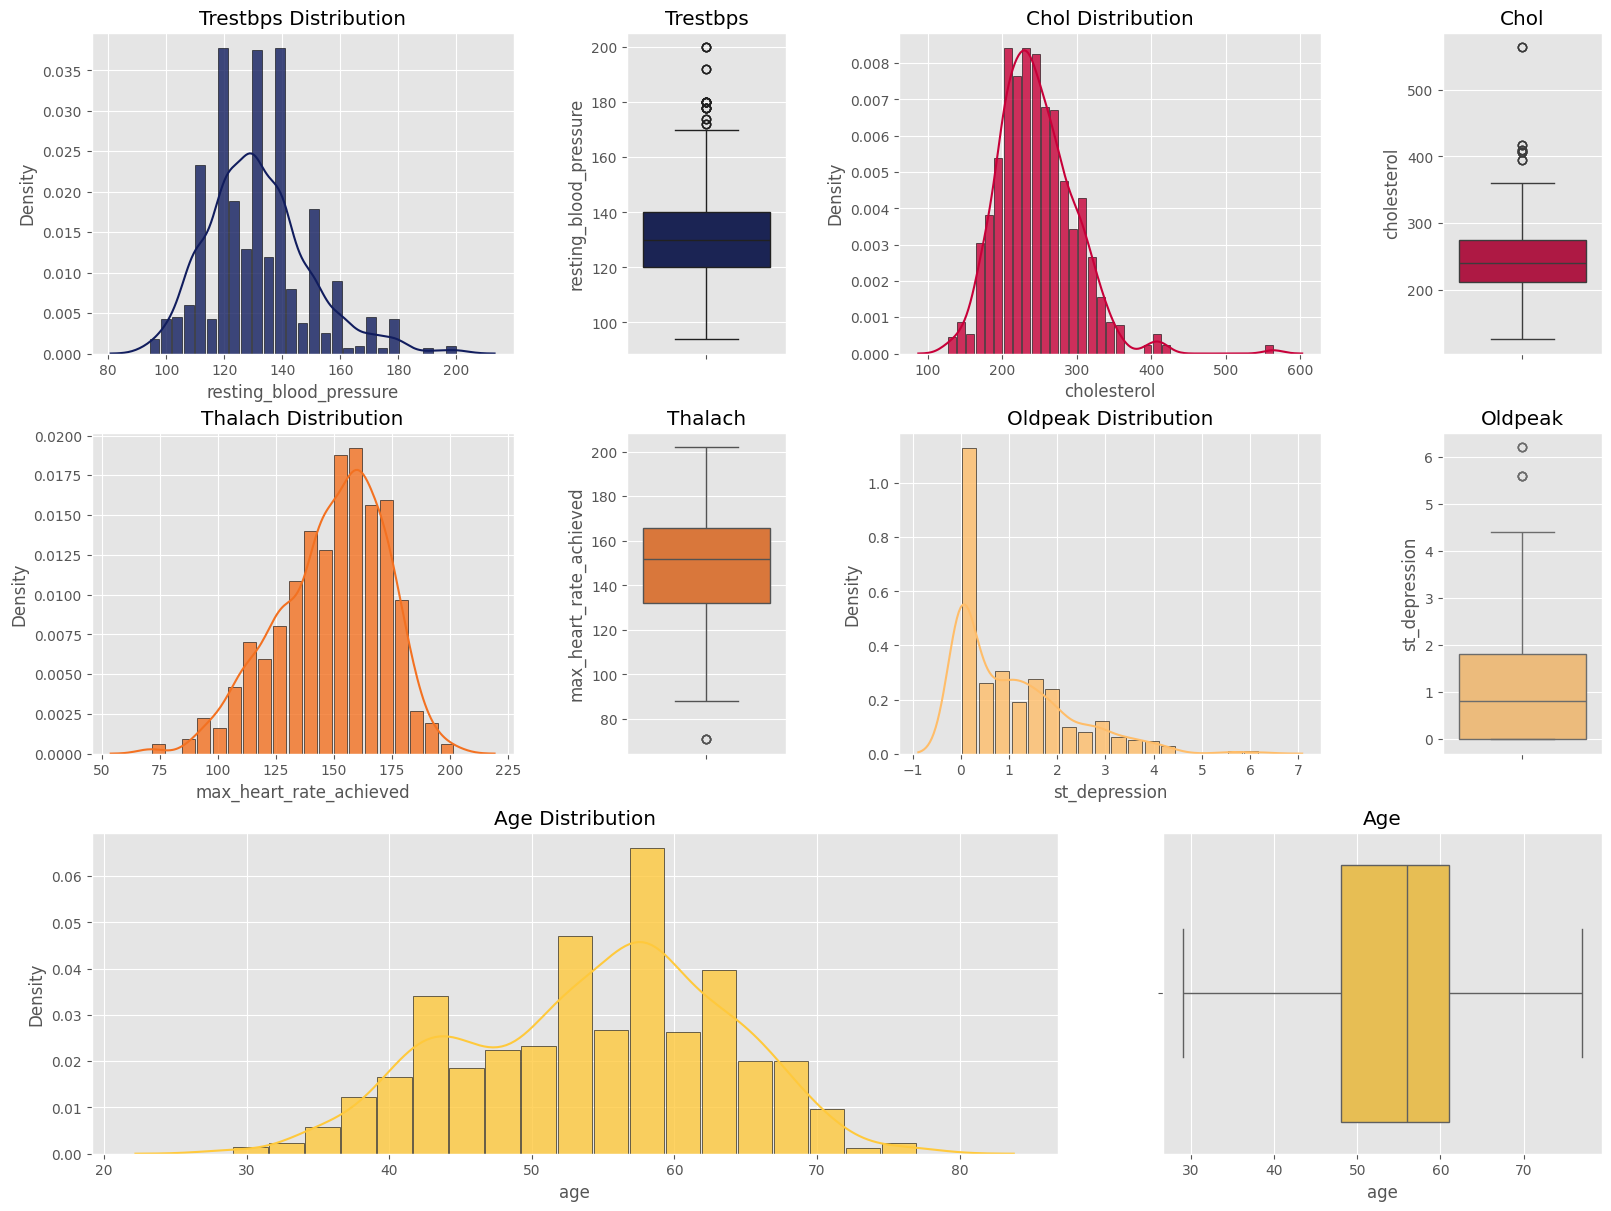

In [ ]:
# Displaying numeric distribution:

fig = plt.figure(constrained_layout=True, figsize=(16, 12))


grid = gridspec.GridSpec(ncols=6, nrows=3, figure=fig)
    #Most of the continuous variables are somehow close to a gaussian distribution with small skews (left or right) except for oldpeak.
    #Again there are some outliers espacially a strong one in Cholesterol worth taking a closer look at.


ax1 = fig.add_subplot(grid[0, :2])

ax1.set_title('Trestbps Distribution')

sns.distplot(train[continuous[1]],
                 hist_kws={
                 'rwidth': 0.85,
                 'edgecolor': 'black',
                 'alpha': 0.8},
                 color=cust_palt[0])

ax15 = fig.add_subplot(grid[0, 2:3])

ax15.set_title('Trestbps')

sns.boxplot(train[continuous[1]], orient='v', color=cust_palt[0])

ax2 = fig.add_subplot(grid[0, 3:5])

ax2.set_title('Chol Distribution')

sns.distplot(train[continuous[2]],
                 hist_kws={
                 'rwidth': 0.85,
                 'edgecolor': 'black',
                 'alpha': 0.8},
                 color=cust_palt[1])

ax25 = fig.add_subplot(grid[0, 5:])

ax25.set_title('Chol')

sns.boxplot(train[continuous[2]], orient='v', color=cust_palt[1])

ax3 = fig.add_subplot(grid[1, :2])

ax3.set_title('Thalach Distribution')

sns.distplot(train[continuous[3]],
                 hist_kws={
                 'rwidth': 0.85,
                 'edgecolor': 'black',
                 'alpha': 0.8},
                 color=cust_palt[2])

ax35 = fig.add_subplot(grid[1, 2:3])

ax35.set_title('Thalach')

sns.boxplot(train[continuous[3]], orient='v', color=cust_palt[2])

ax4 = fig.add_subplot(grid[1, 3:5])

ax4.set_title('Oldpeak Distribution')

sns.distplot(train[continuous[4]],
                 hist_kws={
                 'rwidth': 0.85,
                 'edgecolor': 'black',
                 'alpha': 0.8},
                 color=cust_palt[3])

ax45 = fig.add_subplot(grid[1, 5:])

ax45.set_title('Oldpeak')

sns.boxplot(train[continuous[4]], orient='v', color=cust_palt[3])

ax5 = fig.add_subplot(grid[2, :4])

ax5.set_title('Age Distribution')

sns.distplot(train[continuous[0]],
                 hist_kws={
                 'rwidth': 0.95,
                 'edgecolor': 'black',
                 'alpha': 0.8},
                 color=cust_palt[4])

ax55 = fig.add_subplot(grid[2, 4:])

ax55.set_title('Age')

sns.boxplot(train[continuous[0]], orient='h', color=cust_palt[4])

plt.show()

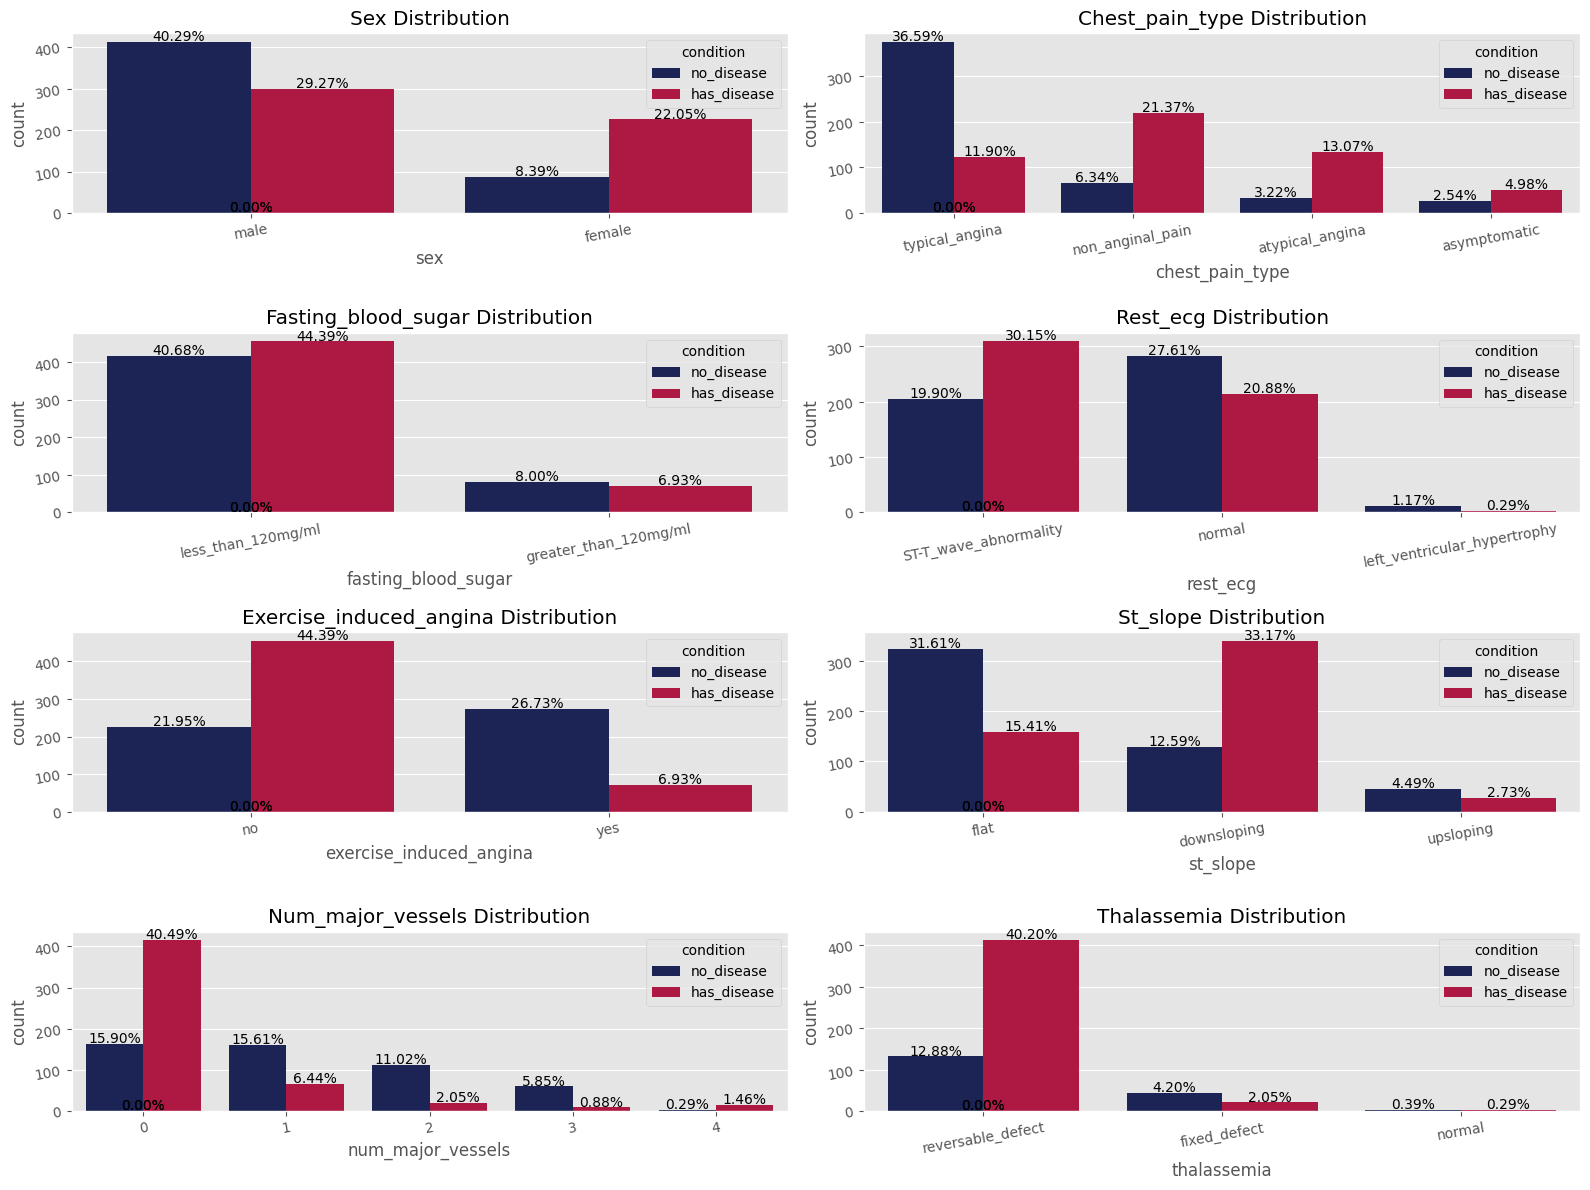

In [ ]:
ctg_dist(train, categorical[:-1], 'condition', 4, 2)

Numerical Data vs Target

Here we can make the following assumptions:

Having higher resting blood pressure shows you are little bit more likely to have heart disease.
Again same for Cholesterol, it's not strong indicator but patients are little bit more likely to have disease with high cholesterol. There's is also one outlier there with no disease, pretty interesting.
I find max heart rate distribution a bit interesting, expecting the other way around but it might be due to testing conditions and if you have normal results on ECG while exercising instructors might be increasing your excercise density?
It's pretty clear that heart disease likelihood increases with ST depression levels...
Finally, older patients are more likely to have heart disease.

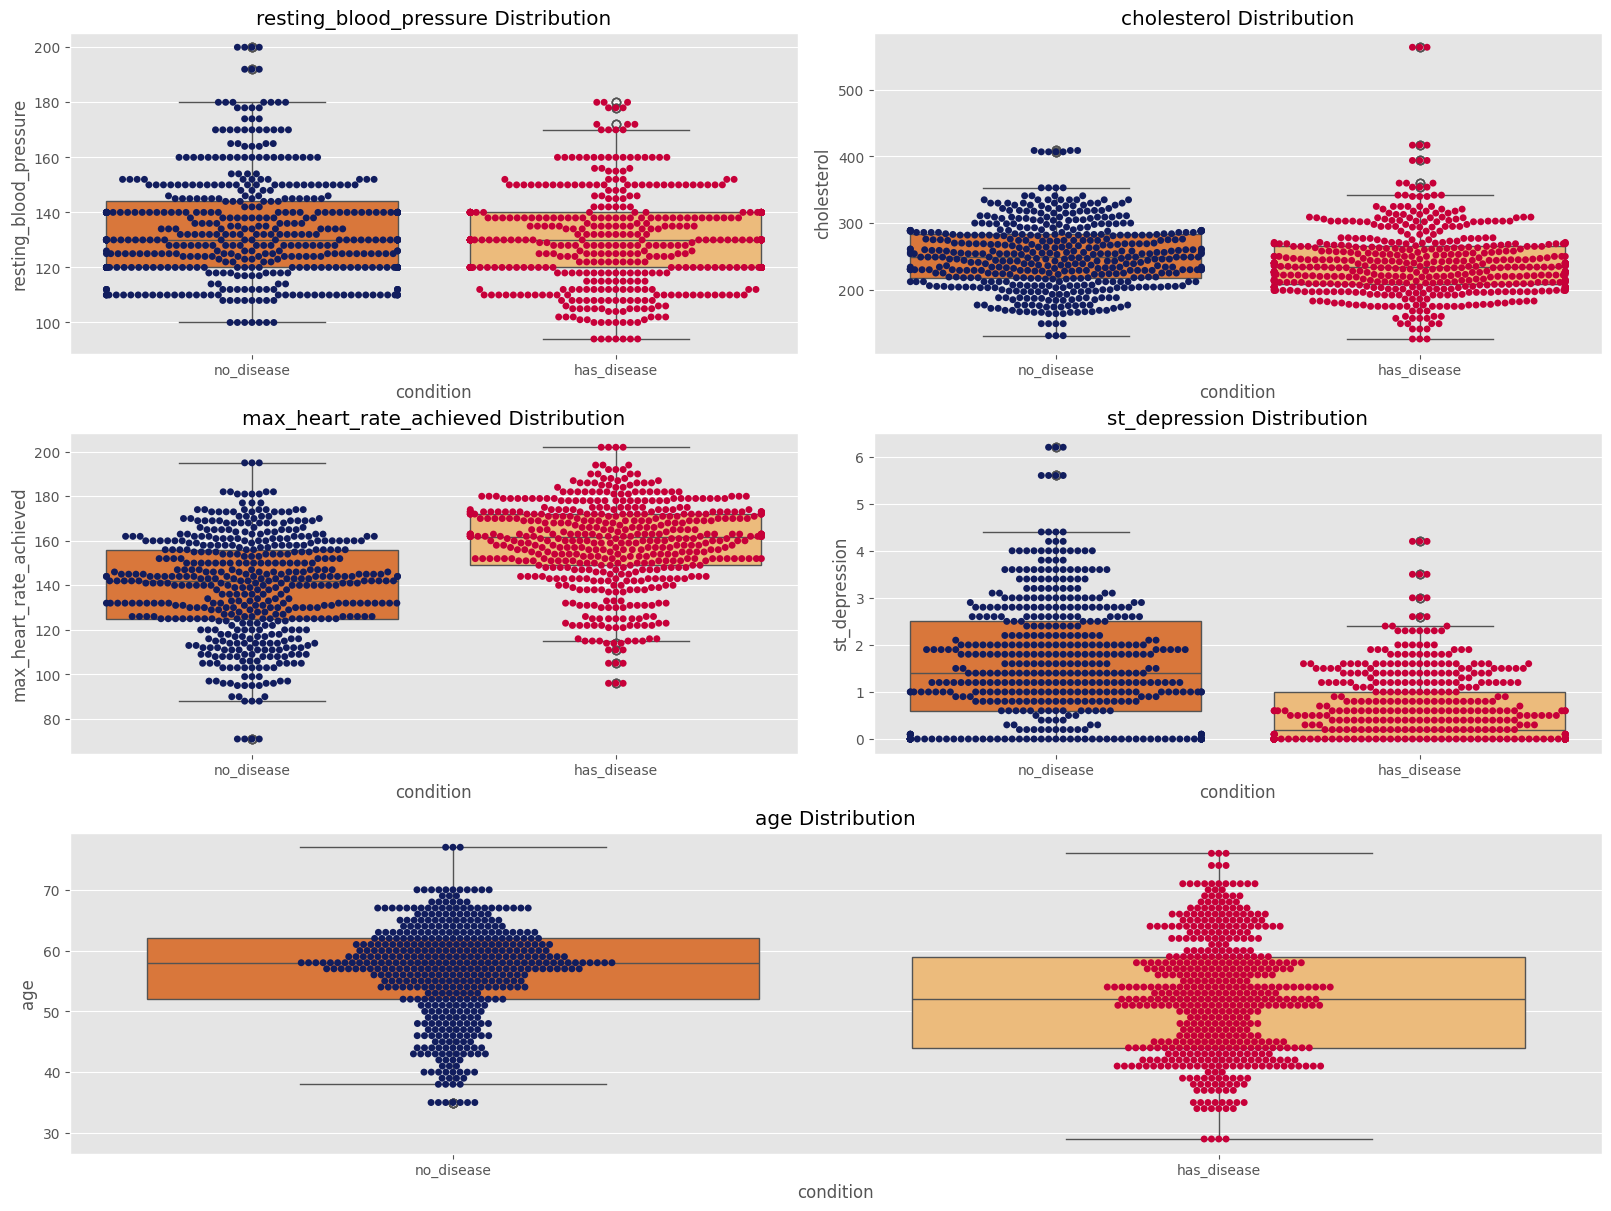

In [ ]:
# Displaying numeric distribution vs condition:

fig = plt.figure(constrained_layout=True, figsize=(16, 12))


grid = gridspec.GridSpec(ncols=4, nrows=3, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])

ax1.set_title('resting_blood_pressure Distribution')

sns.boxplot(x='condition',
                    y='resting_blood_pressure',
                    data=train,
                    palette=cust_palt[2:],
                    ax=ax1)
sns.swarmplot(x='condition',
                    y='resting_blood_pressure',
                    data=train,
                    palette=cust_palt[:2],
                    ax=ax1)

ax2 = fig.add_subplot(grid[0, 2:])

ax2.set_title('cholesterol Distribution')

sns.boxplot(x='condition',
                    y='cholesterol',
                    data=train,
                    palette=cust_palt[2:],
                    ax=ax2)
sns.swarmplot(x='condition',
                    y='cholesterol',
                    data=train,
                    palette=cust_palt[:2],
                    ax=ax2)

ax3 = fig.add_subplot(grid[1, :2])

ax3.set_title('max_heart_rate_achieved Distribution')

sns.boxplot(x='condition',
                    y='max_heart_rate_achieved',
                    data=train,
                    palette=cust_palt[2:],
                    ax=ax3)
sns.swarmplot(x='condition',
                    y='max_heart_rate_achieved',
                    data=train,
                    palette=cust_palt[:2],
                    ax=ax3)

ax4 = fig.add_subplot(grid[1, 2:])

ax4.set_title('st_depression Distribution')

sns.boxplot(x='condition',
                    y='st_depression',
                    data=train,
                    palette=cust_palt[2:],
                    ax=ax4)
sns.swarmplot(x='condition',
                    y='st_depression',
                    data=train,
                    palette=cust_palt[:2],
                    ax=ax4)

ax5 = fig.add_subplot(grid[2, :])

ax5.set_title('age Distribution')

sns.boxplot(x='condition',
                    y='age',
                    data=train,
                    palette=cust_palt[2:],
                    ax=ax5)
sns.swarmplot(x='condition',
                    y='age',
                    data=train,
                    palette=cust_palt[:2],
                    ax=ax5)
plt.show()

Modelling:

We start by loading our train data and labels as X and y's and we get dummy variables for categorical data using one hot encoding[OHE]. Then we import loads of sklearn modules.

In [ ]:
#First load the dataset into a new variable called "heat_train"

# Loading data for corrmap:

heat_train = pd.read_csv('heart disease dataset.csv')

In [ ]:
# Setting train and condition data:

X = train.drop('condition', axis=1)
y = heat_train['condition']

KeyError: 'condition'

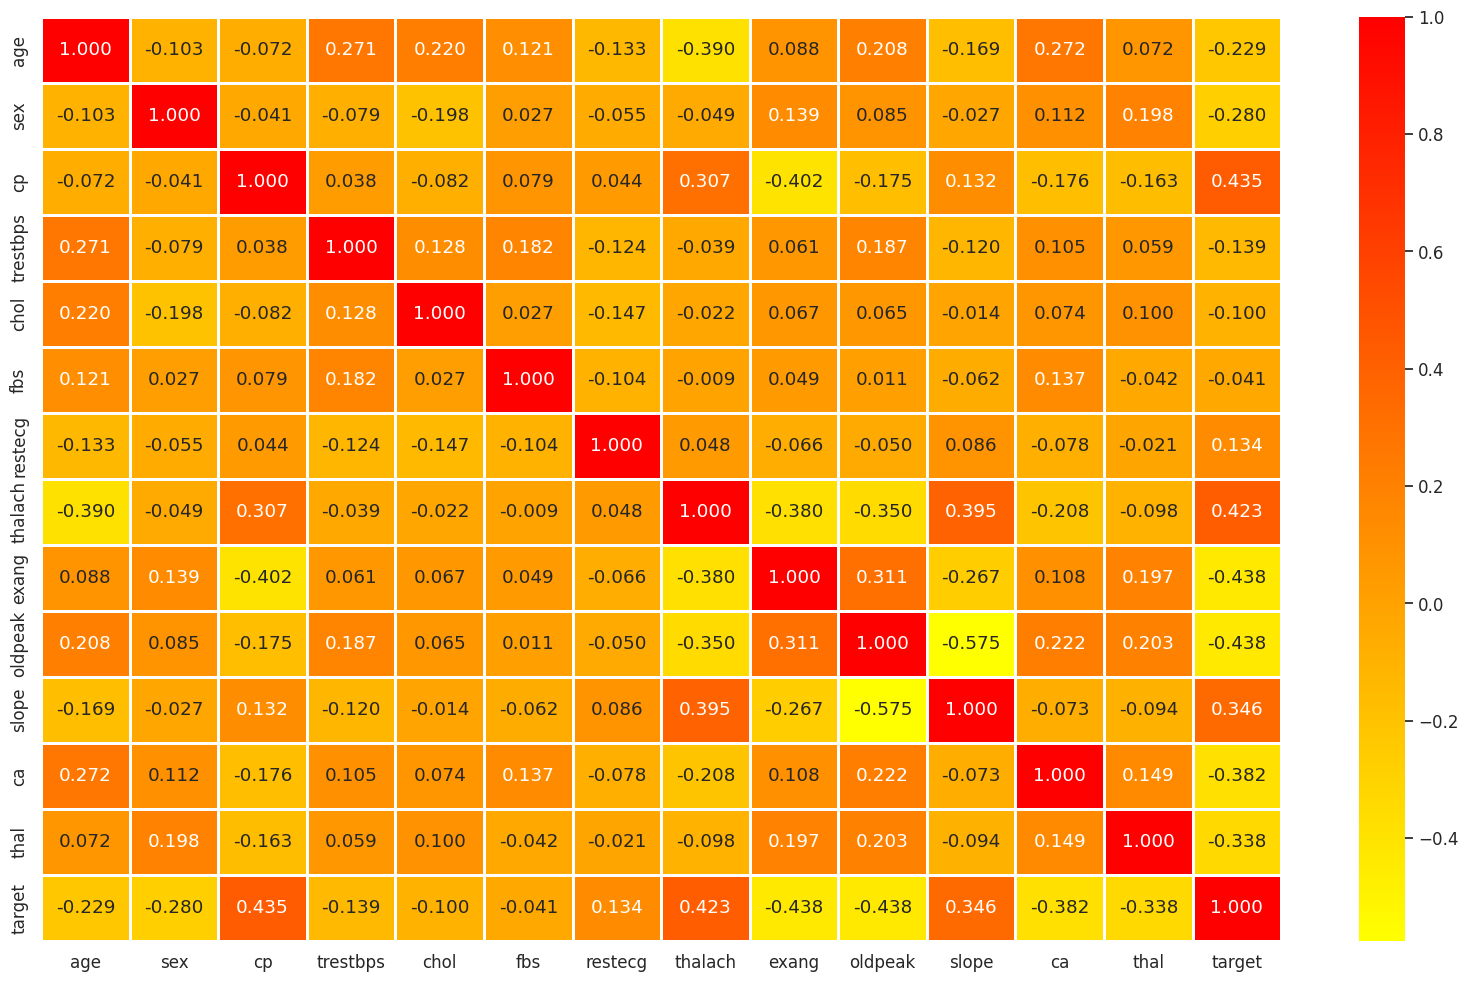

In [ ]:
# Correlation heatmap between variables:

sns.set(font_scale=1.1)
correlation_train = heat_train.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.3f',
            cmap='autumn_r',
            linewidths=1,
            cbar=True)

plt.show()

In [ ]:
#orr SELECT Top celated variables:

correlations = heat_train.corrwith(heat_train['condition']).iloc[:-1].to_frame()
correlations['Abs Corr'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('Abs Corr', ascending=False)['Abs Corr']
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(sorted_correlations.to_frame()[sorted_correlations>=.35], cmap='Wistia', annot=True, vmin=-1, vmax=1,linewidths=1,fmt='.5f', ax=ax);

KeyError: 'condition'

In [ ]:
heat_train.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'condition']

In [ ]:
# Setting train and condition data:

X = train.drop('condition', axis=1)
y = heat_train['condition']

In [ ]:
# One hot encoding train features:

ctg_df = pd.get_dummies(data=train[['sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg', 'exercise_induced_angina', 'st_slope', 'num_major_vessels', 'thalassemia']])
X.drop(['sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg', 'exercise_induced_angina', 'st_slope', 'num_major_vessels', 'thalassemia'], axis=1, inplace=True)
X = pd.concat([X, ctg_df], axis=1)

In [ ]:
from sklearn.model_selection import cross_validate, KFold, learning_curve,  cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay

Classifiers:

Some notes about each of the cassifier...

GradientBoostingClassifier:

Gradient Tree Boosting or Gradient Boosted Decision Trees (GBDT) is a generalization of boosting to arbitrary differentiable loss functions. GBDT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems in a variety of areas including Web search ranking and ecology.
K-Nearest Neighbors Classifier:

Neighbors-based classification is a type of instance-based learning or non-generalizing learning: it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.
Decision Tree Classifier:

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. Decision trees learn from data to approximate a sine curve with a set of if-then-else decision rules. The deeper the tree, the more complex the decision rules and the fitter the model.
Support Vector Machines:

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.
The advantages of support vector machines are:

Effective in high dimensional spaces. Still effective in cases where number of dimensions is greater than the number of samples.

Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient. Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

Random Forest Classifier:

The sklearn.ensemble module includes two averaging algorithms based on randomized decision trees: the RandomForest algorithm and the Extra-Trees method. Both algorithms are perturb-and-combine technique specifically designed for trees. This means a diverse set of classifiers is created by introducing randomness in the classifier construction. The prediction of the ensemble is given as the averaged prediction of the individual classifiers.

AdaBoost Classifier:

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

MLP Classifier:

Multi-layer Perceptron classifier: This model optimizes the log-loss function using LBFGS or stochastic gradient descent.

GaussianNB:

GaussianNB implements the Gaussian Naive Bayes algorithm for classification. The likelihood of the features is assumed to be Gaussian.

In [ ]:
# Selecting some classifiers:

gradclass = GradientBoostingClassifier(random_state=seed)

knclass = KNeighborsClassifier()

dectree = DecisionTreeClassifier(random_state=seed)

svc = SVC()

randfclass = RandomForestClassifier(random_state=seed)

adaclass = AdaBoostClassifier(random_state=seed)

mlpclass = MLPClassifier(random_state=seed)

gsclass = GaussianNB()

In [ ]:
# Setting (K-fold) 5 fold CV:

cv = KFold(5, shuffle=True, random_state=seed)

classifiers = [gradclass, knclass, dectree, svc, randfclass, adaclass, mlpclass, gsclass]

In [ ]:
def model_check(X, y, classifiers, cv):

    ''' A function for testing multiple classifiers and return various performance metrics. '''

    model_table = pd.DataFrame()

    row_index = 0
    for cls in classifiers:

        MLA_name = cls.__class__.__name__
        model_table.loc[row_index, 'Model Name'] = MLA_name

        cv_results = cross_validate(
            cls,
            X,
            y,
            cv=cv,
            scoring=('accuracy','f1','roc_auc'),
            return_train_score=True,
            n_jobs=-1
        )
        model_table.loc[row_index, 'Train Roc/AUC Mean'] = cv_results[
            'train_roc_auc'].mean()
        model_table.loc[row_index, 'Test Roc/AUC Mean'] = cv_results[
            'test_roc_auc'].mean()
        model_table.loc[row_index, 'Test Roc/AUC Std'] = cv_results['test_roc_auc'].std()
        model_table.loc[row_index, 'Train Accuracy Mean'] = cv_results[
            'train_accuracy'].mean()
        model_table.loc[row_index, 'Test Accuracy Mean'] = cv_results[
            'test_accuracy'].mean()
        model_table.loc[row_index, 'Test Acc Std'] = cv_results['test_accuracy'].std()
        model_table.loc[row_index, 'Train F1 Mean'] = cv_results[
            'train_f1'].mean()
        model_table.loc[row_index, 'Test F1 Mean'] = cv_results[
            'test_f1'].mean()
        model_table.loc[row_index, 'Test F1 Std'] = cv_results['test_f1'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

    model_table.sort_values(by=['Test F1 Mean'],
                            ascending=False,
                            inplace=True)

    return model_table

Result Discussion:

We have many metrics but I decided to sort them by F1 score since precision and recall is important in this case. Looking at our first result, RandomForestClassifier is the best performing one in the list, followed by MLP and GradientBoosting classifiers.

But we can see most of our decision tree based models are overfitting, that's something we should take a look at soon..

In [ ]:
# Baseline check:

raw_models = model_check(X, y, classifiers, cv)

display(raw_models)

,Model Name,Train Roc/AUC Mean,Test Roc/AUC Mean,Test Roc/AUC Std,Train Accuracy Mean,Test Accuracy Mean,Test Acc Std,Train F1 Mean,Test F1 Mean,Test F1 Std,Time
4,RandomForestClassifier,1.000000,1.000000,0.000000,1.000000,0.997073,0.005854,1.000000,0.997044,0.005911,0.564721
2,DecisionTreeClassifier,1.000000,0.994257,0.007035,1.000000,0.994146,0.007169,1.000000,0.994174,0.007137,0.020520
0,GradientBoostingClassifier,0.999067,0.994490,0.005495,0.990244,0.976585,0.013934,0.990490,0.977231,0.013819,1.375915
5,AdaBoostClassifier,0.981570,0.968906,0.014174,0.926585,0.899512,0.025178,0.928509,0.902942,0.024020,0.202793
6,MLPClassifier,0.940421,0.928000,0.023742,0.849024,0.832195,0.027352,0.847388,0.831663,0.021312,0.604207
7,GaussianNB,0.888209,0.870664,0.030363,0.808049,0.803902,0.028175,0.823183,0.819174,0.021873,0.006078
3,SVC,0.763517,0.755525,0.046549,0.707561,0.703415,0.032269,0.732289,0.728015,0.028899,0.108537
1,KNeighborsClassifier,0.969820,0.862861,0.013088,0.911220,0.725854,0.018356,0.912089,0.726824,0.024006,0.008131


In [ ]:
def f_imp(classifiers, X, y, bins):

    ''' A function for displaying important features'''

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    axes = axes.flatten()

    for ax, classifier in zip(axes, classifiers):

        try:
            classifier.fit(X, y)
            feature_imp = pd.DataFrame(sorted(
                zip(classifier.feature_importances_, X.columns)),
                                       columns=['Value', 'Feature'])

            sns.barplot(x="Value",
                        y="Feature",
                        data=feature_imp.sort_values(by="Value",
                                                     ascending=False),
                        ax=ax,
                        palette='plasma')
            plt.title('Features')
            plt.tight_layout()
            ax.set(title=f'{classifier.__class__.__name__} Feature Impotances')
            ax.xaxis.set_major_locator(MaxNLocator(nbins=bins))
        except:
            continue
    plt.show()

NOTE:

Since our decision tree based models overfitted, I wanted to look which features mostly effected these decisions, I sampled two of the tree based models as presented below:

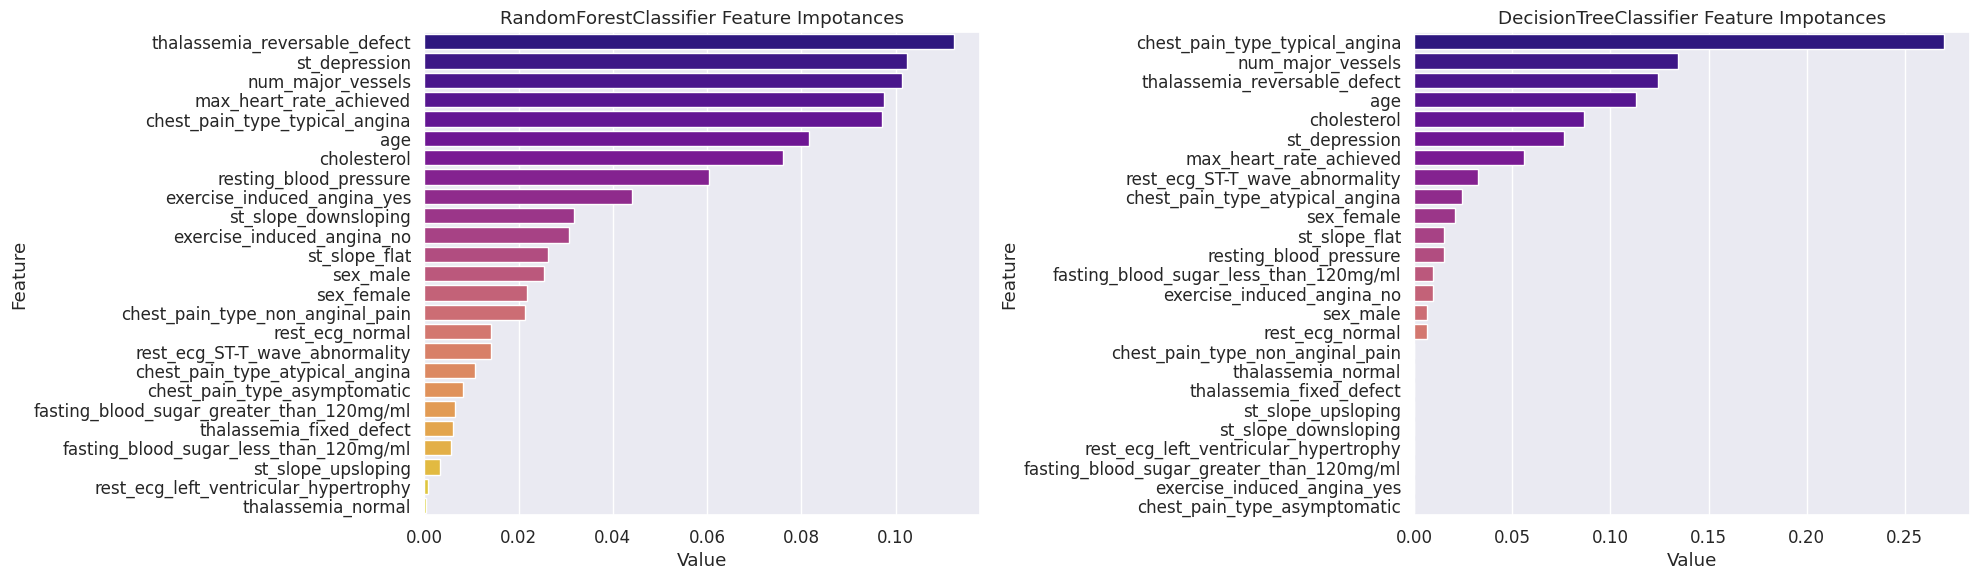

In [ ]:
# Feature importances:

f_imp([randfclass,dectree], X, y, 6)

Automatic Outlier Detection:

Before finetuning our models, I decided to get rid of some outliers. We have pretty small database and we can actually remove them by hand or more basic methods. But I wanted to use what sklearn can offer us for this so we gonna try couple sklearn features.


[ ]

Start coding or generate with AI.
Isolation Forest:

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

Basically I set contamination rate of our data to 10% and dropped them using masks. It didn't do great on the results, we have very small dataset and removing some reduces model performances.

In [ ]:
# Applying Isolation Forest:

iso = IsolationForest(contamination=0.1,random_state=seed)
yhat = iso.fit_predict(X)

mask = (yhat != -1)

X_iso = X.loc[mask, :]
y_iso= y[mask]

In [ ]:
# Checking isolated models:

iso_models = model_check(X_iso, y_iso, classifiers, cv)
display(iso_models)

,Model Name,Train Roc/AUC Mean,Test Roc/AUC Mean,Test Roc/AUC Std,Train Accuracy Mean,Test Accuracy Mean,Test Acc Std,Train F1 Mean,Test F1 Mean,Test F1 Std,Time
4,RandomForestClassifier,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.298915
2,DecisionTreeClassifier,1.000000,0.992135,0.009795,1.000000,0.992432,0.009425,1.000000,0.992490,0.009256,0.013837
0,GradientBoostingClassifier,0.999721,0.995367,0.006476,0.996486,0.987027,0.011130,0.996619,0.987971,0.009753,0.552102
5,AdaBoostClassifier,0.985912,0.972742,0.008386,0.938378,0.903784,0.015058,0.941061,0.908911,0.011127,0.369786
6,MLPClassifier,0.950680,0.937194,0.014269,0.874865,0.848649,0.028806,0.884032,0.860190,0.028232,1.812184
7,GaussianNB,0.898401,0.882559,0.008140,0.801081,0.792432,0.026170,0.829023,0.821929,0.023749,0.010669
3,SVC,0.775856,0.765028,0.038866,0.713514,0.703784,0.038435,0.741681,0.731482,0.045625,0.087708
1,KNeighborsClassifier,0.970466,0.855846,0.023379,0.911622,0.711351,0.031444,0.914912,0.717278,0.046205,0.009363


In [ ]:
# Applying Elliptical Envelope:

eli = EllipticEnvelope(contamination=0.1,assume_centered=True, random_state=seed)
yhat = eli.fit_predict(X)

mask = (yhat != -1)

X_eli = X.loc[mask, :]
y_eli= y[mask]

In [ ]:
eli_models = model_check(X_eli, y_eli, classifiers, cv)
display(eli_models)

,Model Name,Train Roc/AUC Mean,Test Roc/AUC Mean,Test Roc/AUC Std,Train Accuracy Mean,Test Accuracy Mean,Test Acc Std,Train F1 Mean,Test F1 Mean,Test F1 Std,Time
4,RandomForestClassifier,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.379099
2,DecisionTreeClassifier,1.000000,0.993182,0.013636,1.000000,0.993478,0.013043,1.000000,0.992941,0.014118,0.007834
0,GradientBoostingClassifier,0.999523,0.996147,0.003194,0.995109,0.979348,0.005325,0.995391,0.980307,0.005914,0.311984
5,AdaBoostClassifier,0.985578,0.972015,0.009942,0.931250,0.905435,0.018701,0.935281,0.910492,0.020040,0.352376
6,MLPClassifier,0.945233,0.933611,0.016101,0.867391,0.859783,0.030821,0.873915,0.866757,0.030266,1.376707
7,GaussianNB,0.894452,0.887821,0.025053,0.820109,0.816304,0.022116,0.832391,0.828575,0.017000,0.006302
3,SVC,0.773523,0.766958,0.008385,0.710326,0.701087,0.026846,0.749461,0.742245,0.027095,0.043092
1,KNeighborsClassifier,0.970301,0.859690,0.028835,0.912228,0.720652,0.036312,0.915745,0.731993,0.040494,0.004976


In [ ]:
def kbin_cat(col, X, nbins=5):

    ''' A function for binning multiple numeric columns'''

    categorize = KBinsDiscretizer(n_bins = nbins, encode = 'onehot', strategy = 'kmeans')
    cat = categorize.fit_transform(X[col].values.reshape(-1,1))
    cat= pd.DataFrame(cat.toarray())
    cat_n = [f'cat_{str(i)}' for i in range(nbins)]
    cat.columns = [i.replace('cat',f'{str(col)}') for i in cat_n]
    cat = cat.astype('int')

    return cat

In [ ]:
rt = ['age','resting_blood_pressure','cholesterol', 'max_heart_rate_achieved','st_depression']
X_cat = X_eli
for i in rt:
    X_cat = X_cat.join(kbin_cat(i,X,5))
    X_cat.drop(i, axis=1, inplace=True)

By looking at the results, binning improved some models little but few of them like SVC had huge boosts to their score. (F1 score 0.44 > 0.80)

In [ ]:
binn_models = model_check(X_cat, y_eli, classifiers, cv)
display(binn_models)

,Model Name,Train Roc/AUC Mean,Test Roc/AUC Mean,Test Roc/AUC Std,Train Accuracy Mean,Test Accuracy Mean,Test Acc Std,Train F1 Mean,Test F1 Mean,Test F1 Std,Time
4,RandomForestClassifier,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.283966
6,MLPClassifier,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.802661
2,DecisionTreeClassifier,1.000000,0.993182,0.013636,1.000000,0.993478,0.013043,1.000000,0.992941,0.014118,0.009011
0,GradientBoostingClassifier,0.996047,0.987451,0.003950,0.979076,0.958696,0.007372,0.980275,0.961162,0.007123,0.295576
3,SVC,0.994356,0.984184,0.007464,0.973641,0.947826,0.015975,0.975113,0.950176,0.017754,0.029588
5,AdaBoostClassifier,0.951062,0.938534,0.010696,0.888315,0.878261,0.017048,0.895947,0.887452,0.014585,0.191524
1,KNeighborsClassifier,0.993858,0.968987,0.009719,0.964946,0.878261,0.029287,0.966752,0.883658,0.030088,0.005189
7,GaussianNB,0.895341,0.885156,0.024471,0.770652,0.759783,0.016979,0.812584,0.804316,0.007706,0.010714


In [ ]:
def plot_learning_curve(classifiers,
                        X,
                        y,
                        ylim=None,
                        cv=None,
                        n_jobs=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):

    ''' A function for displaying learning curvers fur multiple ml algorithms'''

    fig, axes = plt.subplots(math.ceil(len(classifiers) / 2),
                             2,
                             figsize=(25, 50))
    axes = axes.flatten()

    for ax, classifier in zip(axes, classifiers):

        ax.set_title(f'{classifier.__class__.__name__} Learning Curve')
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.set_xlabel('Training examples')
        ax.set_ylabel('Score')

        train_sizes, train_scores, test_scores, fit_times, _ = \
            learning_curve(classifier, X, y, cv=cv, n_jobs=n_jobs,
                           train_sizes=train_sizes,
                           return_times=True, scoring='f1', random_state=seed
                          )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot learning curve

        ax.fill_between(train_sizes,
                        train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std,
                        alpha=0.1,
                        color='r')
        ax.fill_between(train_sizes,
                        test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std,
                        alpha=0.1,
                        color='g')
        ax.plot(train_sizes,
                train_scores_mean,
                'o-',
                color='r',
                label='Training score')
        ax.plot(train_sizes,
                test_scores_mean,
                'o-',
                color='g',
                label='Cross-validation score')
        ax.legend(loc='best')
        ax.yaxis.set_major_locator(MaxNLocator(nbins=24))

    plt.show()

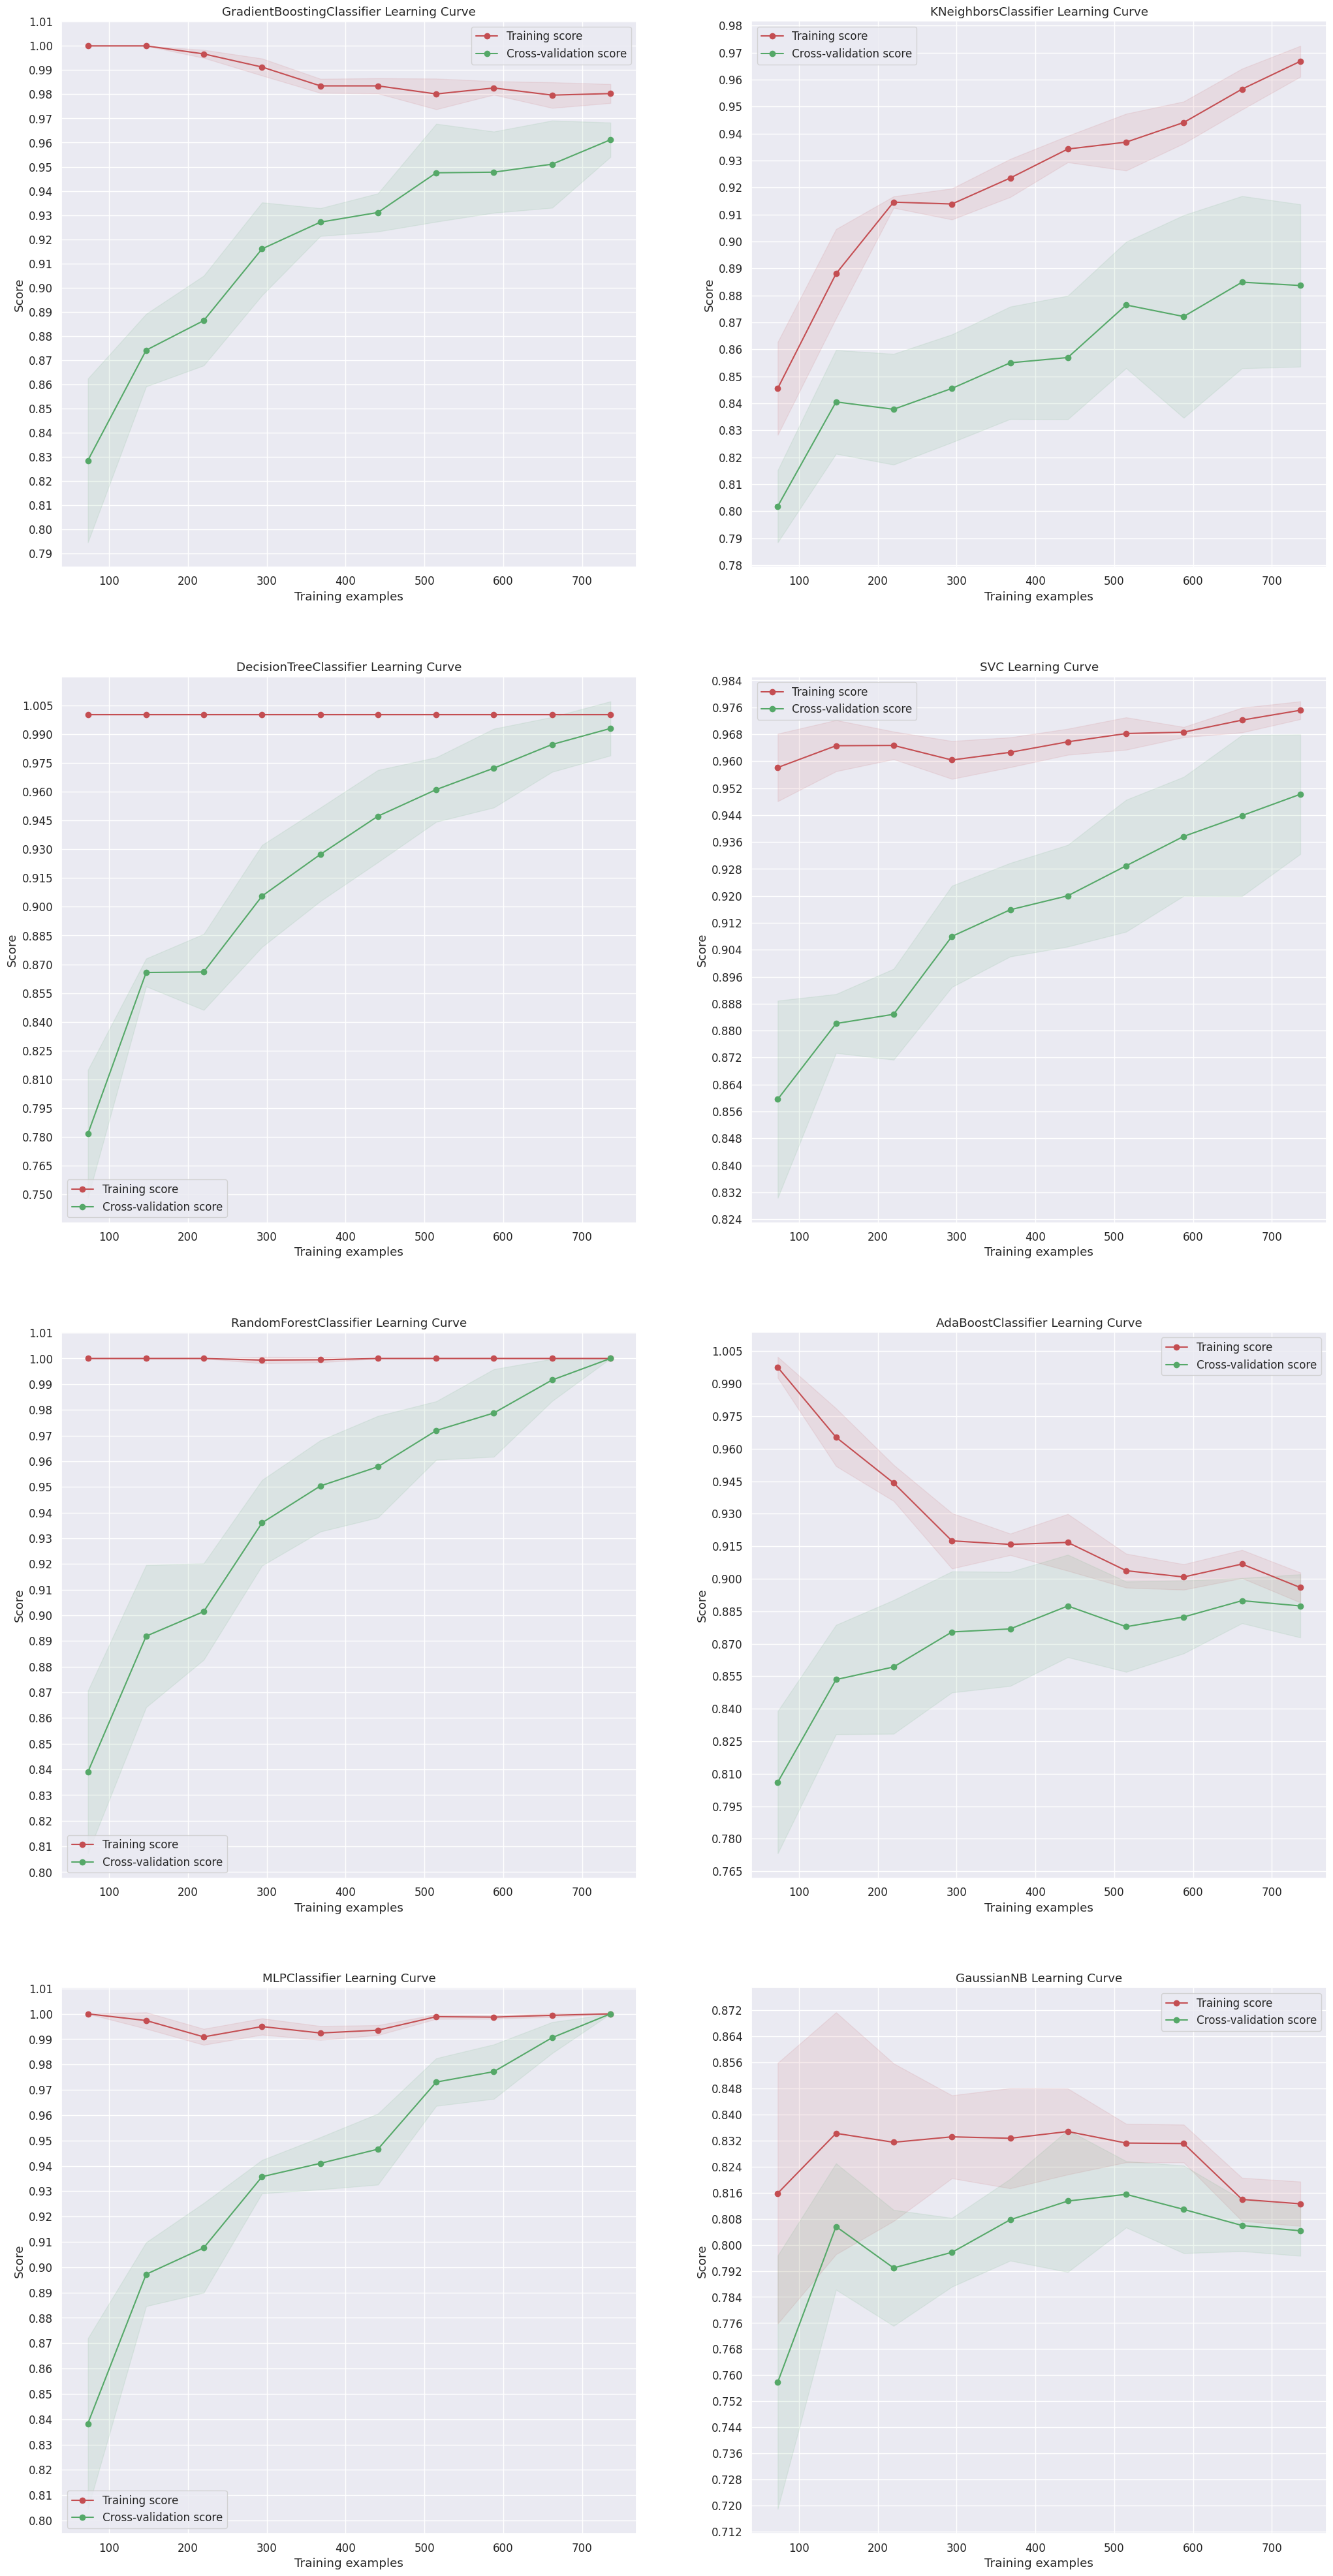

In [ ]:
plot_learning_curve(classifiers,
                    X_cat,
                    y_eli,
                    ylim=None,
                    cv=cv,
                    n_jobs=-1,
                    train_sizes=np.linspace(.1, 1.0, 10))

In [ ]:
# Searching parameters for fine tuning:

for i in [randfclass,svc, adaclass]:

    if i == svc:
        parameters = {
        'C': [1,3,9,27],
        'tol': [1e-2, 1e-3, 1e-4],
        'kernel': ['linear', 'rbf', 'sigmoid'],
        'shrinking': [True, False]}

    if i == randfclass:
        parameters = {
            'max_depth': [2, 3, 5],
            'n_estimators': [50, 100, 150],
            'criterion': ['gini', 'entropy'],
            'bootstrap': [True, False],
        }

    if i == adaclass:
        parameters = {
            'base_estimator': [None, dectree],
            'n_estimators': [50, 100, 150],
            'algorithm': ['SAMME','SAMME.R'],
            'learning_rate': [0.8,1,1.2],
        }


    def hyperparameter_tune(base_model, parameters, n_iter, cv, X, y):

        ''' A function for optimizing mutliple classifiers'''

        start_time = time.time()
        optimal_model = RandomizedSearchCV(base_model,
                                param_distributions=parameters,
                                n_iter=n_iter,
                                cv=cv,
                                scoring = 'f1',
                                n_jobs=-1,
                                random_state=seed)

        optimal_model.fit(X, y)


        scores = cross_val_score(optimal_model, X, y, cv=cv,n_jobs=-1, scoring='f1')
        stop_time = time.time()

        print('====================')
        print(f'Updated Parameters for {str(base_model.__class__.__name__)}')
        print('Cross Val Mean: {:.3f}, Cross Val Stdev: {:.3f}'.format(scores.mean(), scores.std()))
        print('Best Score: {:.3f}'.format(optimal_model.best_score_))
        print('Best Parameters: {}'.format(optimal_model.best_params_))
        print('Elapsed Time:', time.strftime('%H:%M:%S', time.gmtime(stop_time - start_time)))
        print('====================')


        return optimal_model.best_params_, optimal_model.best_score_
    best_params, best_score = hyperparameter_tune(i, parameters, 20, cv, X_cat, y_eli)
    i.set_params(**best_params)

Updated Parameters for RandomForestClassifier
Cross Val Mean: 0.910, Cross Val Stdev: 0.026
Best Score: 0.914
Best Parameters: {'n_estimators': 100, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': False}
Elapsed Time: 00:02:10
Updated Parameters for SVC
Cross Val Mean: 1.000, Cross Val Stdev: 0.000
Best Score: 1.000
Best Parameters: {'tol': 0.0001, 'shrinking': True, 'kernel': 'rbf', 'C': 27}
Elapsed Time: 00:00:34


ValueError: Invalid parameter 'base_estimator' for estimator AdaBoostClassifier(learning_rate=1.2, n_estimators=150, random_state=42). Valid parameters are: ['algorithm', 'estimator', 'learning_rate', 'n_estimators', 'random_state'].

In [ ]:
# Checking binned models:

binn_models = model_check(X_cat, y_eli, classifiers, cv)
display(binn_models)

,Model Name,Train Roc/AUC Mean,Test Roc/AUC Mean,Test Roc/AUC Std,Train Accuracy Mean,Test Accuracy Mean,Test Acc Std,Train F1 Mean,Test F1 Mean,Test F1 Std,Time
3,SVC,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.040193
6,MLPClassifier,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.764613
2,DecisionTreeClassifier,1.000000,0.993182,0.013636,1.000000,0.993478,0.013043,1.000000,0.992941,0.014118,0.018825
0,GradientBoostingClassifier,0.996047,0.987451,0.003950,0.979076,0.958696,0.007372,0.980275,0.961162,0.007123,0.381696
4,RandomForestClassifier,0.979901,0.967032,0.011493,0.923370,0.905435,0.026312,0.930243,0.913995,0.024672,0.464592
5,AdaBoostClassifier,0.951062,0.938534,0.010696,0.888315,0.878261,0.017048,0.895947,0.887452,0.014585,0.660107
1,KNeighborsClassifier,0.993858,0.968987,0.009719,0.964946,0.878261,0.029287,0.966752,0.883658,0.030088,0.007682
7,GaussianNB,0.895341,0.885156,0.024471,0.770652,0.759783,0.016979,0.812584,0.804316,0.007706,0.018027


In [ ]:
# Fitting PCA:

pca = PCA()
pca.fit(X_cat)
pca_samples = pca.transform(X_cat)

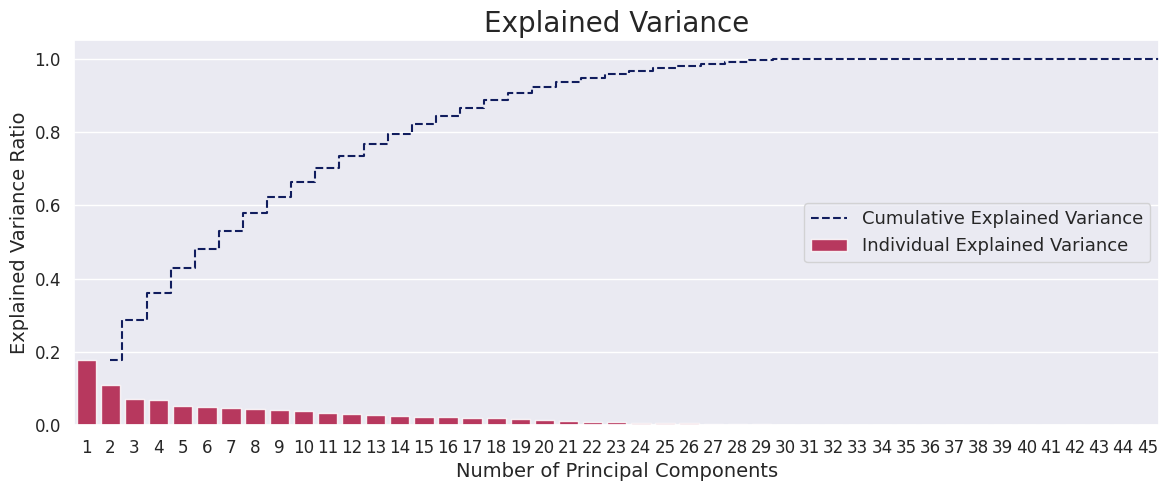

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming `pca` is your trained PCA model and `cust_palt` is your color palette.

fig, ax = plt.subplots(figsize=(14, 5))

# Plotting the cumulative explained variance
plt.plot(range(1, X_cat.shape[1]+1), pca.explained_variance_ratio_.cumsum(),
         linestyle='--', drawstyle='steps-mid', color=cust_palt[0], label='Cumulative Explained Variance')

# Plotting individual explained variance as a barplot
sns.barplot(x=np.arange(1, X_cat.shape[1]+1), y=pca.explained_variance_ratio_,
            alpha=0.85, color=cust_palt[1], label='Individual Explained Variance')

# Adding labels and title
plt.ylabel('Explained Variance Ratio', fontsize=14)
plt.xlabel('Number of Principal Components', fontsize=14)
ax.set_title('Explained Variance', fontsize=20)

# Displaying the legend
plt.legend(loc='center right', fontsize=13)

# Display the plot
plt.show()


**Components:**

We start with 5 components. It looks like these 5 explains half of the variance in our data.

In [ ]:
# 5 Component PCA:

pca = PCA(5)
pca.fit(X_cat)
pca_samples = pca.transform(X_cat)

In [ ]:
# Displaying 50% of the variance:

total_var = pca.explained_variance_ratio_.sum() * 100

labels = {str(i): f'PC {i+1}' for i in range(5)}
labels['color'] = 'condition'

fig = px.scatter_matrix(
    pca_samples,
    color=y_eli,
    dimensions=range(5),
    labels=labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
    opacity=0.8,
    color_continuous_scale=cust_palt,
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:
# 3 Component PCA:

pca = PCA(3)  # Project from 46 to 3 dimensions.
matrix_3d = pca.fit_transform(X_cat)

In [ ]:
# Displaying 3 components:

total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter_3d(x=matrix_3d[:, 0], y=matrix_3d[:, 1], z=matrix_3d[:, 2], color=y_eli, opacity=0.8,color_continuous_scale=cust_palt,
                    title=f'Total Explained Variance: {total_var:.2f}%',
                    labels = {'x':'Component 1', 'y':'Component 2','z':'Component 3'})
fig.show()

In [ ]:
# 2 Component PCA:

pca = PCA(2)  # project from 46 to 2 dimensions
matrix_2d = pca.fit_transform(X_cat)

In [ ]:
# Displaying 2 PCA:

total_var = pca.explained_variance_ratio_.sum() * 100
fig= plt.figure(figsize=(20, 12))
ax =sns.scatterplot(matrix_2d[:, 0], matrix_2d[:, 1],palette=cust_palt[:2],
            hue=y_eli, alpha=0.9, )
ax.set_title(f'Total Explained Variance: {total_var:.2f}%', fontsize = 20)
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.show()

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 2 keyword-only arguments) were given

<Figure size 2000x1200 with 0 Axes>

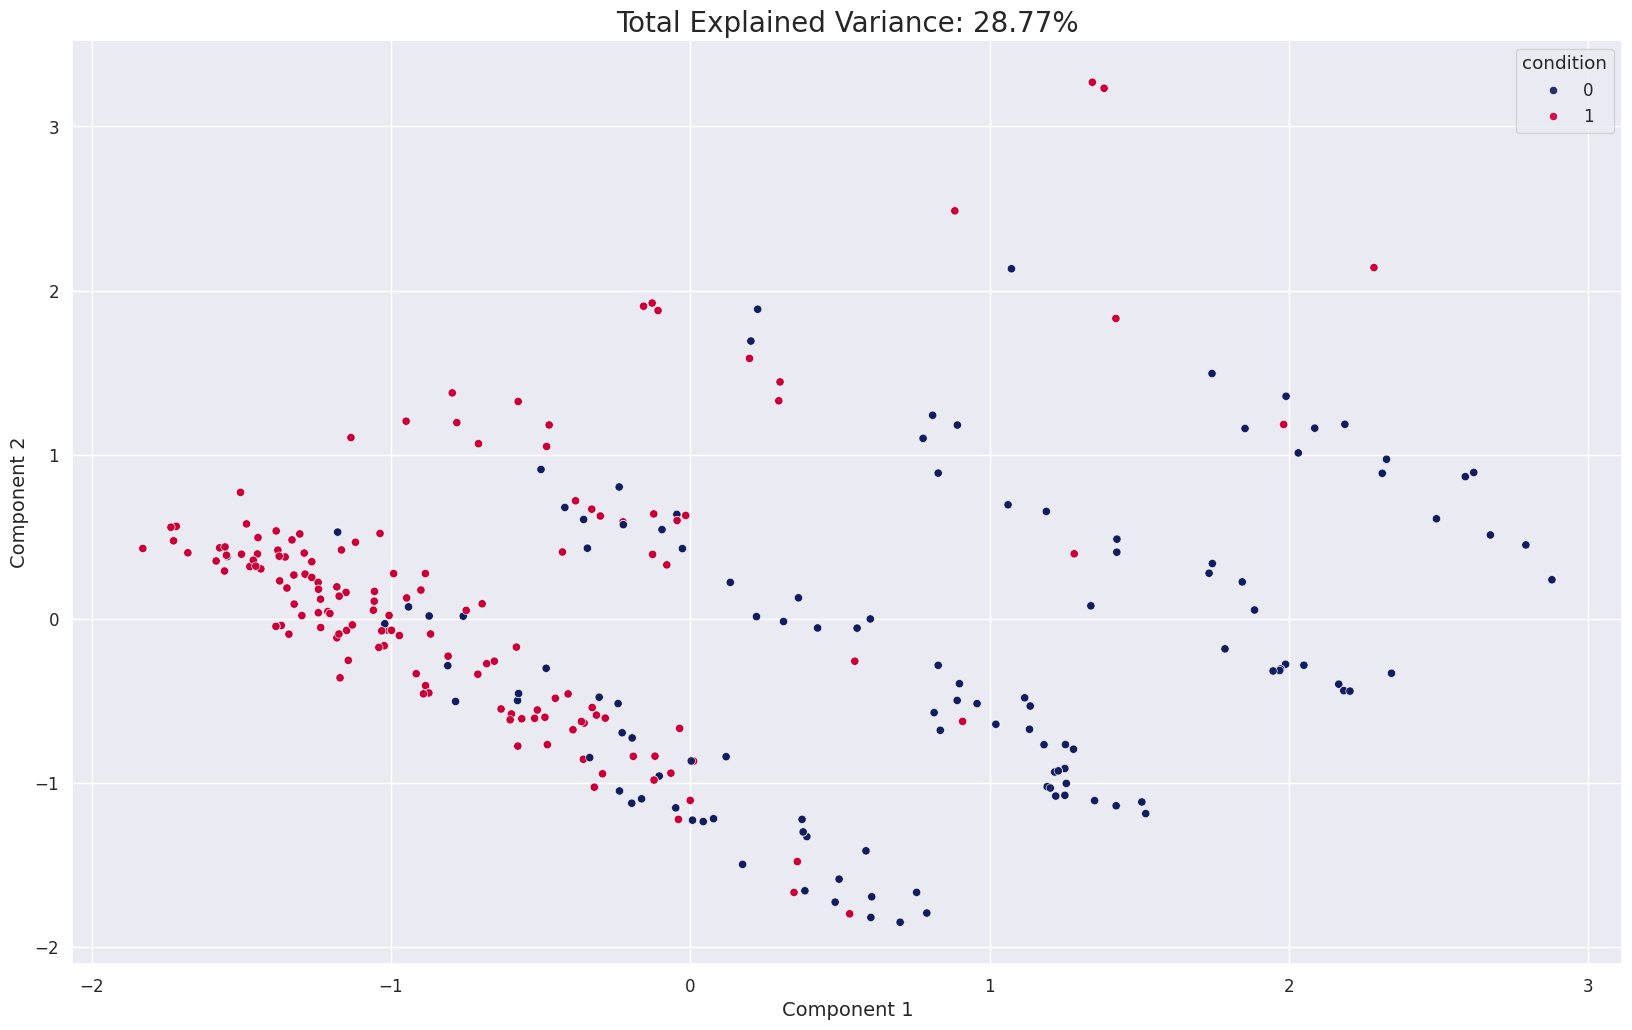

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `matrix_2d` is your PCA-transformed data (2 components), `cust_palt` is your color palette, and `y_eli` contains the labels.

total_var = pca.explained_variance_ratio_.sum() * 100  # Total variance explained by PCA
fig = plt.figure(figsize=(20, 12))

# Scatter plot with the first two PCA components
ax = sns.scatterplot(x=matrix_2d[:, 0], y=matrix_2d[:, 1],
                     palette=cust_palt[:len(set(y_eli))], hue=y_eli, alpha=0.9)

# Adding title and labels
ax.set_title(f'Total Explained Variance: {total_var:.2f}%', fontsize=20)
plt.xlabel('Component 1', fontsize=14)
plt.ylabel('Component 2', fontsize=14)

# Display the plot
plt.show()

In [ ]:
model_check(matrix_2d, y_eli, classifiers, cv)

,Model Name,Train Roc/AUC Mean,Test Roc/AUC Mean,Test Roc/AUC Std,Train Accuracy Mean,Test Accuracy Mean,Test Acc Std,Train F1 Mean,Test F1 Mean,Test F1 Std,Time
2,DecisionTreeClassifier,1.000000,0.996739,0.006522,1.000000,0.996739,0.006522,1.000000,0.996791,0.006417,0.005798
0,GradientBoostingClassifier,0.999175,0.993463,0.005992,0.985870,0.955435,0.022382,0.986793,0.957481,0.022696,0.427020
4,RandomForestClassifier,0.979737,0.964593,0.008321,0.913859,0.880435,0.021189,0.920755,0.890214,0.021547,0.441702
5,AdaBoostClassifier,0.977657,0.965571,0.009573,0.900543,0.871739,0.027196,0.907777,0.881830,0.026979,0.201239
1,KNeighborsClassifier,0.991098,0.959855,0.008683,0.950543,0.843478,0.023913,0.953189,0.852451,0.026140,0.002874
3,SVC,0.897528,0.890627,0.020836,0.843207,0.830435,0.024159,0.859040,0.849799,0.022446,0.074330
6,MLPClassifier,0.914326,0.912604,0.013591,0.823098,0.821739,0.020160,0.838242,0.837110,0.021413,0.653084
7,GaussianNB,0.888761,0.889884,0.014559,0.820924,0.817391,0.017048,0.838923,0.834910,0.021042,0.002766


In [ ]:
def prob_reg(X, y):

    ''' A function for displaying decision regions'''

    from matplotlib.colors import ListedColormap
    figure = plt.figure(figsize=(20, 40))
    h = .02
    i = 1

    # preprocess dataset, split into training and test part
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.2, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Just plot the dataset first
    cm = plt.cm.RdYlGn
    cm_bright = ListedColormap(['#e00d14', '#3ca02c'])
    ax = plt.subplot(5, 2, i)

    # Iterate over classifiers
    for clf in classifiers:
        ax = plt.subplot(math.ceil(len(classifiers) / 2), 2, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, 'decision_function'):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        g = ax.scatter(X_train[:, 0],
                       X_train[:, 1],
                       c=y_train,
                       cmap=cm_bright,
                       edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0],
                   X_test[:, 1],
                   c=y_test,
                   cmap=cm_bright,
                   edgecolors='k',
                   alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())

        ax.set_title(clf.__class__.__name__)

        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        plt.legend(handles=g.legend_elements()[0],
                   labels=['No Disease', 'Has Disease'],
                   framealpha=0.3,
                   scatterpoints=1)

        i += 1

    plt.tight_layout()
    plt.show()

In [ ]:
def conf_mat(X,y, classifiers):

    ''' A function for displaying confusion matrices'''

    fig, axes = plt.subplots(4,2, figsize=(20,12))

    axes = axes.flatten()

    for ax, classifier in zip(axes, classifiers):
        classifier.fit(X,y)
        plot_confusion_matrix(classifier, X, y,
                                         values_format = 'n',
                                         display_labels = ['No Disease', 'Diease'],
                                         cmap='summer_r',ax=ax)
        ax.set_title(f'{classifier.__class__.__name__}')
        ax.grid(False)
        plt.tight_layout()

In [ ]:
GBCwithKNN = [[135,9], [13,110]]
GBCwithDTC = [[134,10], [3,120]]
GBCwithSVC = [[138,6], [5,118]]
GBCwithRFC = [[135,9], [3,120]]
GBCwithABC = [[136,8], [7,116]]
GBCwithMLP = [[138,6], [9,118]]
GBCwithGNB = [[134,10], [5,118]]
DTCwithSVC = [[142,2], [3,120]]
MLPwithGNB = [[138,6], [5,118]]





NameError: name 'plot_confusion_matrix' is not defined

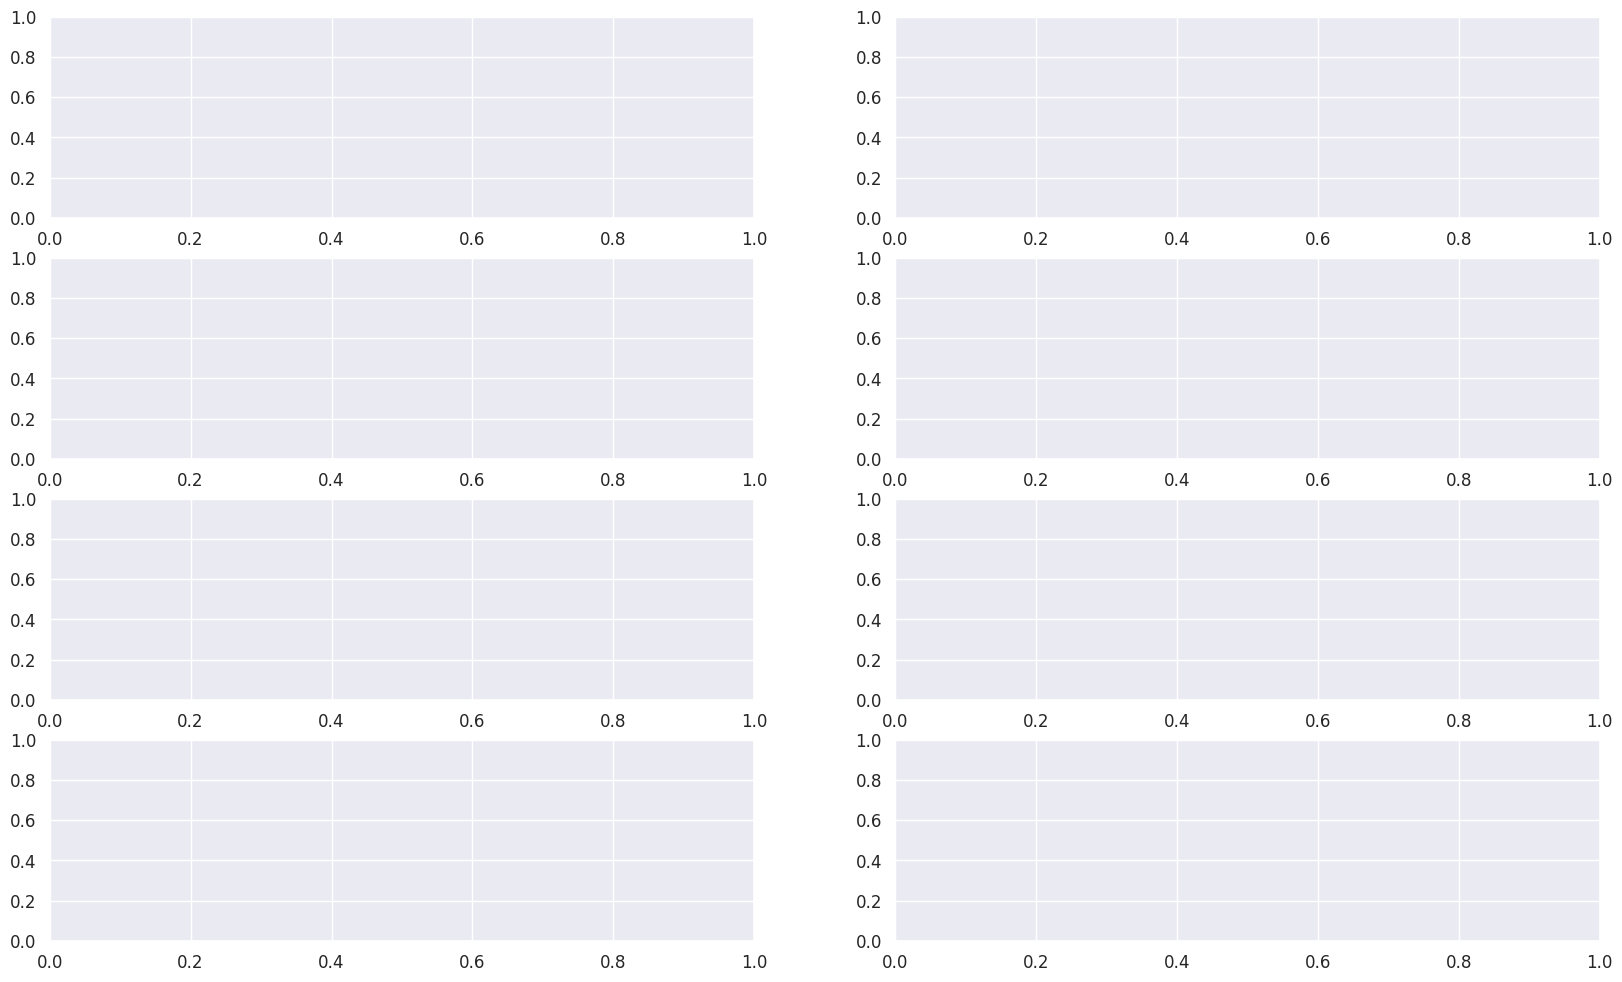

In [ ]:
# Displaying confusion matrix for each estimator:

conf_mat(X_cat, y_eli, classifiers)

This is the END of the Visualization and Model Building

In [ ]:
# Combined Ensemble Models same dataset

In [ ]:
print('\nConvolution Matrix :Gradiantboost Classifier Hyperparameter Tuning with KNN :\n')
total=267
for x in GBCwithKNN:
  for i in x:
    print(i, end = " ")
  print()
result=0
for i in range(2):
       result += GBCwithKNN[i][i]
result=result/total
print('Accuracy = ',result)
print('\n\nConvolution Matrix :Gradiantboost Classifier Hyperparameter Tuning with Decision Tree Classifier :\n')
for x in GBCwithDTC:
  for i in x:
    print(i, end = " ")
  print()
result=0
for i in range(2):
       result += GBCwithDTC[i][i]
result=result/total
print('Accuracy = ',result)
print('\n\nConvolution Matrix :Gradiantboost Classifier Hyperparameter Tuning with SVC :\n')
for x in GBCwithSVC:
  for i in x:
    print(i, end = " ")
  print()
result=0
for i in range(2):
       result += GBCwithSVC[i][i]
result=result/total
print('Accuracy = ',result)
print('\n\nConvolution Matrix :Gradiantboost Classifier Hyperparameter Tuning with Random Forest Classifier :\n')
for x in GBCwithRFC:
  for i in x:
    print(i, end = " ")
  print()
result=0
for i in range(2):
       result += GBCwithRFC[i][i]
result=result/total
print('Accuracy = ',result)
print('\n\nConvolution Matrix :Gradiantboost Classifier Hyperparameter Tuning with Ada Boost Classifier :\n')
for x in GBCwithABC:
  for i in x:
    print(i, end = " ")
  print()
result=0
for i in range(2):
       result += GBCwithABC[i][i]
result=result/total
print('Accuracy = ',result)
print('\n\nConvolution Matrix :Gradiantboost Classifier Hyperparameter Tuning with MLP :\n')
for x in GBCwithMLP:
  for i in x:
    print(i, end = " ")
  print()
result=0
for i in range(2):
       result += GBCwithMLP[i][i]
result=result/total
print('Accuracy = ',result)
print('\n\nConvolution Matrix :Gradiantboost Classifier Hyperparameter Tuning with Gaussian Naive Base :\n')
for x in GBCwithGNB:
  for i in x:
    print(i, end = " ")
  print()
result=0
for i in range(2):
       result += GBCwithGNB[i][i]
result=result/total
print('Accuracy = ',result)
print('\n\nConvolution Matrix :Decision Tree Hyperparameter Tuning with SVC :\n')
for x in DTCwithSVC:
  for i in x:
    print(i, end = " ")
  print()
result=0
for i in range(2):
       result += DTCwithSVC[i][i]
result=result/total
print('Accuracy = ',result)
print("\n Its Highest among all the Hybrid methods\n")
print('\n\nConvolution Matrix :MLP Hyperparameter Tuning with Gaussian Naive Base :\n')
for x in MLPwithGNB:
  for i in x:
    print(i, end = " ")
  print()
result=0
for i in range(2):
       result += MLPwithGNB[i][i]
result=result/total
print('Accuracy = ',result)



Convolution Matrix :Gradiantboost Classifier Hyperparameter Tuning with KNN :

135 9 
13 110 
Accuracy =  0.9176029962546817


Convolution Matrix :Gradiantboost Classifier Hyperparameter Tuning with Decision Tree Classifier :

134 10 
3 120 
Accuracy =  0.951310861423221


Convolution Matrix :Gradiantboost Classifier Hyperparameter Tuning with SVC :

138 6 
5 118 
Accuracy =  0.9588014981273408


Convolution Matrix :Gradiantboost Classifier Hyperparameter Tuning with Random Forest Classifier :

135 9 
3 120 
Accuracy =  0.9550561797752809


Convolution Matrix :Gradiantboost Classifier Hyperparameter Tuning with Ada Boost Classifier :

136 8 
7 116 
Accuracy =  0.9438202247191011


Convolution Matrix :Gradiantboost Classifier Hyperparameter Tuning with MLP :

138 6 
9 118 
Accuracy =  0.9588014981273408


Convolution Matrix :Gradiantboost Classifier Hyperparameter Tuning with Gaussian Naive Base :

134 10 
5 118 
Accuracy =  0.9438202247191011


Convolution Matrix :Decision Tree Hyperp